## Capstone Project - The Battle of Neighborhoods Report

Import required libraries

In [233]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium==0.5.0
import folium # map rendering library

#import beautiful soup
from urllib.request import urlopen
from bs4 import BeautifulSoup


print('Libraries imported.')

Libraries imported.


### Download and Explore New York Dataset

New York has a total of 5 boroughs and 306 neighborhoods. In order to explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 
Luckily, this dataset exists for free on the web https://geo.nyu.edu/catalog/nyu_2451_34572. I have downloaded this dataset nyu-2452-34572-geojson.json to my computer and stored in the same folder as that of this notebook 

Let's load the dataset

In [234]:
with open('nyu-2451-34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [235]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [236]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [237]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

In [238]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# let's loop through the data and fill the dataframe one row at a time.

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [239]:
pd.set_option('max_colwidth', -1)

Quickly examine the resulting dataframe.

In [240]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [241]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Use geopy library to get the latitude and longitude values of New York City

In [242]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [243]:
# create map of New York using latitude and longitude values

map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

As the problem we are going to solve using FourSqare API is find out Italian Restaurents with more likes in Manhattan, let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [244]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)


Let's check size of Manhattan data

In [245]:
manhattan_data.shape

(40, 4)

Let's examine first 10 rows of Manhattan data

In [246]:
manhattan_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688
5,Manhattan,Manhattanville,40.816934,-73.957385
6,Manhattan,Central Harlem,40.815976,-73.943211
7,Manhattan,East Harlem,40.792249,-73.944182
8,Manhattan,Upper East Side,40.775639,-73.960508
9,Manhattan,Yorkville,40.775930,-73.947118


Use geopy library to get the latitude and longitude values of of Manhattan.

As we did with all of New York City, let's visualize Manhattan and the neighborhoods in it.

In [247]:
address = 'Manhattan, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


In [248]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods to find Italian restaurents.

Accessing Foursquare API

First, let's create the GET request URL. Name your URL url.

Define Foursquare Credentials and Version

In [249]:
CLIENT_ID = 'MNWSNBXHLZTKECU1LVEGYIT2J0O5EEU3A4VPRCLASMLYAUHU' # Foursquare ID
CLIENT_SECRET = 'YUGXU45BD3QEQ1PSPDT3EN3NIAV5DIY15LRTWD2BNPICHSKW' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MNWSNBXHLZTKECU1LVEGYIT2J0O5EEU3A4VPRCLASMLYAUHU
CLIENT_SECRET:YUGXU45BD3QEQ1PSPDT3EN3NIAV5DIY15LRTWD2BNPICHSKW


Let's us define search criteria

In [250]:
search_query = 'Italian restaurent'
radius = 5000
print(search_query + ' .... OK!')

Italian restaurent .... OK!


Define Url to make FourSquare API to retreive venues with search query

In [251]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=MNWSNBXHLZTKECU1LVEGYIT2J0O5EEU3A4VPRCLASMLYAUHU&client_secret=YUGXU45BD3QEQ1PSPDT3EN3NIAV5DIY15LRTWD2BNPICHSKW&ll=40.7900869,-73.9598295&v=20180605&query=Italian restaurent&radius=5000&limit=100'

Send the request and get results

In [252]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d5c90c6075a42002f5f9b99'},
 'response': {'venues': [{'id': '4a7778a1f964a5209be41fe3',
    'name': "Carmine's Italian Restaurant",
    'location': {'address': '2450 Broadway',
     'crossStreet': 'btwn W 90th & W 91st',
     'lat': 40.7910963,
     'lng': -73.9739914,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.7910963,
       'lng': -73.9739914}],
     'distance': 1198,
     'postalCode': '10024',
     'cc': 'US',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['2450 Broadway (btwn W 90th & W 91st)',
      'New York, NY 10024',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d110941735',
      'name': 'Italian Restaurant',
      'pluralName': 'Italian Restaurants',
      'shortName': 'Italian',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
       'suffix': '.png'},
      'primary': True}],
    'delivery': {'id': '294727',


From the results json data received from FourSquare, we know all the information is in the venues key. Before we proceed, let's create the get_category_type function.

In [253]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [254]:
# venues = results['response']['groups'][0]['items']
venues = results['response']['venues']   
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['id','name', 'categories', 'location.lat', 'location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]



Let's check the size of venues dataset

In [255]:
nearby_venues.shape

(50, 5)

Let's check how many Italian venues were returned by FourSquare by checking the size of the resulting dataframe

In [256]:
nearby_venues.head(10)

,id,name,categories,lat,lng
0,4a7778a1f964a5209be41fe3,Carmine's Italian Restaurant,Italian Restaurant,40.791096,-73.973991
1,51e7310c498e639ed27062b1,Quality Italian,Italian Restaurant,40.764476,-73.977032
2,4ba00318f964a520285237e3,The Italian Academy (Casa Italiana),General College & University,40.807645,-73.960396
3,4a90dbbef964a520a11920e3,Italian Village Pizzeria,Pizza Place,40.772669,-73.952319
4,3fd66200f964a5209ee81ee3,Carmine’s Italian Restaurant,Italian Restaurant,40.757497,-73.986779
5,4f5ba6bee4b085f52d735495,Italian Cultural Institute,History Museum,40.768890,-73.965602
6,4f32883519836c91c7e0fe4f,Italian Eatery,Italian Restaurant,40.801706,-73.961285
7,4b786cecf964a52052cd2ee3,Bellini Italian Restaurant & Brick Oven Pizza,Italian Restaurant,40.784656,-73.973522
8,4c4465312d3ec9b6bdc52eae,Italian Trade Commission,Government Building,40.768454,-73.967386
9,4e7a3a40775b9ed4d3844232,Italian Cousin,Pizza Place,40.803357,-73.963440


In [257]:
nearby_venues= nearby_venues[nearby_venues.categories.str.contains("Italian Restaurant")]
nearby_venues.shape


(21, 5)

In [258]:
nearby_venues.reset_index(drop=True, inplace=True)
nearby_venues.head(10)

,id,name,categories,lat,lng
0,4a7778a1f964a5209be41fe3,Carmine's Italian Restaurant,Italian Restaurant,40.791096,-73.973991
1,51e7310c498e639ed27062b1,Quality Italian,Italian Restaurant,40.764476,-73.977032
2,3fd66200f964a5209ee81ee3,Carmine’s Italian Restaurant,Italian Restaurant,40.757497,-73.986779
3,4f32883519836c91c7e0fe4f,Italian Eatery,Italian Restaurant,40.801706,-73.961285
4,4b786cecf964a52052cd2ee3,Bellini Italian Restaurant & Brick Oven Pizza,Italian Restaurant,40.784656,-73.973522
5,4e4c4d06bd413c4cc66856b9,Italian Caterers,Italian Restaurant,40.805768,-73.966000
6,525d7bde498e3a406f590b1d,Davio's North Italian Steakhouse,Italian Restaurant,40.753233,-73.974774
7,42f15a80f964a520bb261fe3,Olive Garden,Italian Restaurant,40.759414,-73.984702
8,4c8174d42f1c236a66213043,Italian Tomato,Italian Restaurant,40.819351,-73.960352
9,4f44a2bd19836ed0019571be,Mama Mia 44sw Italian Cuisine,Italian Restaurant,40.759716,-73.991829


In [259]:
#let's get a list of ids of venues
venue_id_list = nearby_venues['id'].tolist()
venue_id_list

['4a7778a1f964a5209be41fe3',
 '51e7310c498e639ed27062b1',
 '3fd66200f964a5209ee81ee3',
 '4f32883519836c91c7e0fe4f',
 '4b786cecf964a52052cd2ee3',
 '4e4c4d06bd413c4cc66856b9',
 '525d7bde498e3a406f590b1d',
 '42f15a80f964a520bb261fe3',
 '4c8174d42f1c236a66213043',
 '4f44a2bd19836ed0019571be',
 '4c5742f5d12a20a1545766bd',
 '5a457b8d3b83076b58991a87',
 '53d0596d498e713d024c6506',
 '4d573d8aa747b60cc83b332b',
 '3fd66200f964a520a2e91ee3',
 '50356a65e4b045e72e72263f',
 '4e4e4dadbd4101d0d7a73f72',
 '50024e24e4b093944cc9f94a',
 '4dd5302cb0fb7a332e7a3444',
 '4af0e7f3f964a52009e021e3',
 '4ed3a608754ad8083f7d96de']

Set up to pull the likes from the FourSquare API based on venue ID, store in a like_list and print

In [260]:
#set up to pull the likes from the API based on venue ID

url_list = []
likes_count_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    likes_count_list.append(likes)
print(likes_count_list)


[385, 678, 1570, 0, 32, 0, 57, 867, 0, 17, 1, 0, 0, 337, 58, 0, 0, 1, 50, 129, 0]


Let's check if we received likes for all the venues

In [261]:
#double check that we did not lose any venues based on if likes were available

print(len(likes_count_list))
print(len(venue_id_list))

21
21


Add the total_likes column to nearby_venues dataframe from like_list 

In [262]:
# add in the likes count
nearby_venues['likes count'] = likes_count_list
nearby_venues.head()

,id,name,categories,lat,lng,likes count
0,4a7778a1f964a5209be41fe3,Carmine's Italian Restaurant,Italian Restaurant,40.791096,-73.973991,385
1,51e7310c498e639ed27062b1,Quality Italian,Italian Restaurant,40.764476,-73.977032,678
2,3fd66200f964a5209ee81ee3,Carmine’s Italian Restaurant,Italian Restaurant,40.757497,-73.986779,1570
3,4f32883519836c91c7e0fe4f,Italian Eatery,Italian Restaurant,40.801706,-73.961285,0
4,4b786cecf964a52052cd2ee3,Bellini Italian Restaurant & Brick Oven Pizza,Italian Restaurant,40.784656,-73.973522,32


Let's categorize venues based on likes count by adding computed grade column

In [263]:
# let's define a function that will add new column grade to venues based on likes count

def getGrade(s):
    if s['likes count']<=50:
        return 'poor'
    if s['likes count']<=100:
        return 'average'
    if s['likes count']<=200:
        return 'good'
    if s['likes count']<=500:
        return 'great'
    if s['likes count']>500:
        return 'awesome'

nearby_venues['grade']=nearby_venues.apply(getGrade, axis=1)

In [264]:
nearby_venues.head(8)

,id,name,categories,lat,lng,likes count,grade
0,4a7778a1f964a5209be41fe3,Carmine's Italian Restaurant,Italian Restaurant,40.791096,-73.973991,385,great
1,51e7310c498e639ed27062b1,Quality Italian,Italian Restaurant,40.764476,-73.977032,678,awesome
2,3fd66200f964a5209ee81ee3,Carmine’s Italian Restaurant,Italian Restaurant,40.757497,-73.986779,1570,awesome
3,4f32883519836c91c7e0fe4f,Italian Eatery,Italian Restaurant,40.801706,-73.961285,0,poor
4,4b786cecf964a52052cd2ee3,Bellini Italian Restaurant & Brick Oven Pizza,Italian Restaurant,40.784656,-73.973522,32,poor
5,4e4c4d06bd413c4cc66856b9,Italian Caterers,Italian Restaurant,40.805768,-73.966000,0,poor
6,525d7bde498e3a406f590b1d,Davio's North Italian Steakhouse,Italian Restaurant,40.753233,-73.974774,57,average
7,42f15a80f964a520bb261fe3,Olive Garden,Italian Restaurant,40.759414,-73.984702,867,awesome


In [265]:
# one hot encoding
to_onehot = pd.get_dummies(nearby_venues[['grade']], prefix="", prefix_sep="")

# add vaenue name column back to dataframe
to_onehot['Name'] = nearby_venues['name'] 

# move venue name column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

to_onehot.head()

,Name,average,awesome,good,great,poor
0,Carmine's Italian Restaurant,0,0,0,1,0
1,Quality Italian,0,1,0,0,0
2,Carmine’s Italian Restaurant,0,1,0,0,0
3,Italian Eatery,0,0,0,0,1
4,Bellini Italian Restaurant & Brick Oven Pizza,0,0,0,0,1


In [266]:
cluster_df = to_onehot.drop('Name', axis=1)
k_clusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 1, 1, 0, 0, 0, 2, 1, 0, 0])

In [267]:
nearby_venues['cluster'] = kmeans.labels_
nearby_venues.head(8)

,id,name,categories,lat,lng,likes count,grade,cluster
0,4a7778a1f964a5209be41fe3,Carmine's Italian Restaurant,Italian Restaurant,40.791096,-73.973991,385,great,3
1,51e7310c498e639ed27062b1,Quality Italian,Italian Restaurant,40.764476,-73.977032,678,awesome,1
2,3fd66200f964a5209ee81ee3,Carmine’s Italian Restaurant,Italian Restaurant,40.757497,-73.986779,1570,awesome,1
3,4f32883519836c91c7e0fe4f,Italian Eatery,Italian Restaurant,40.801706,-73.961285,0,poor,0
4,4b786cecf964a52052cd2ee3,Bellini Italian Restaurant & Brick Oven Pizza,Italian Restaurant,40.784656,-73.973522,32,poor,0
5,4e4c4d06bd413c4cc66856b9,Italian Caterers,Italian Restaurant,40.805768,-73.966000,0,poor,0
6,525d7bde498e3a406f590b1d,Davio's North Italian Steakhouse,Italian Restaurant,40.753233,-73.974774,57,average,2
7,42f15a80f964a520bb261fe3,Olive Garden,Italian Restaurant,40.759414,-73.984702,867,awesome,1


In [268]:
nearby_venues.head(8)

,id,name,categories,lat,lng,likes count,grade,cluster
0,4a7778a1f964a5209be41fe3,Carmine's Italian Restaurant,Italian Restaurant,40.791096,-73.973991,385,great,3
1,51e7310c498e639ed27062b1,Quality Italian,Italian Restaurant,40.764476,-73.977032,678,awesome,1
2,3fd66200f964a5209ee81ee3,Carmine’s Italian Restaurant,Italian Restaurant,40.757497,-73.986779,1570,awesome,1
3,4f32883519836c91c7e0fe4f,Italian Eatery,Italian Restaurant,40.801706,-73.961285,0,poor,0
4,4b786cecf964a52052cd2ee3,Bellini Italian Restaurant & Brick Oven Pizza,Italian Restaurant,40.784656,-73.973522,32,poor,0
5,4e4c4d06bd413c4cc66856b9,Italian Caterers,Italian Restaurant,40.805768,-73.966000,0,poor,0
6,525d7bde498e3a406f590b1d,Davio's North Italian Steakhouse,Italian Restaurant,40.753233,-73.974774,57,average,2
7,42f15a80f964a520bb261fe3,Olive Garden,Italian Restaurant,40.759414,-73.984702,867,awesome,1


 Let's visualize the resulting clusters

In [270]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

venues = nearby_venues_sort_by_likes
# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues['lat'], venues['lng'], venues['name'], nearby_venues_sort_by_likes['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Let's examine each cluster and determine the discriminating venue categories that distinguish each cluster.

Cluster 0

In [271]:
nearby_venues.loc[nearby_venues['cluster']==0]

,id,name,categories,lat,lng,likes count,grade,cluster
3,4f32883519836c91c7e0fe4f,Italian Eatery,Italian Restaurant,40.801706,-73.961285,0,poor,0
4,4b786cecf964a52052cd2ee3,Bellini Italian Restaurant & Brick Oven Pizza,Italian Restaurant,40.784656,-73.973522,32,poor,0
5,4e4c4d06bd413c4cc66856b9,Italian Caterers,Italian Restaurant,40.805768,-73.966000,0,poor,0
8,4c8174d42f1c236a66213043,Italian Tomato,Italian Restaurant,40.819351,-73.960352,0,poor,0
9,4f44a2bd19836ed0019571be,Mama Mia 44sw Italian Cuisine,Italian Restaurant,40.759716,-73.991829,17,poor,0
10,4c5742f5d12a20a1545766bd,Italian Tomato,Italian Restaurant,40.816234,-73.979814,1,poor,0
11,5a457b8d3b83076b58991a87,The Italian Brothers,Italian Restaurant,40.759424,-73.969038,0,poor,0
12,53d0596d498e713d024c6506,Italian Bistro - Time Square,Italian Restaurant,40.760656,-73.984000,0,poor,0
15,50356a65e4b045e72e72263f,Italian Danish Food Mafia,Italian Restaurant,40.744689,-73.979539,0,poor,0
16,4e4e4dadbd4101d0d7a73f72,New York Italian Kitchen #2,Italian Restaurant,40.798402,-73.963482,0,poor,0


Cluster 1

In [272]:
nearby_venues.loc[nearby_venues['cluster']==1]

,id,name,categories,lat,lng,likes count,grade,cluster
1,51e7310c498e639ed27062b1,Quality Italian,Italian Restaurant,40.764476,-73.977032,678,awesome,1
2,3fd66200f964a5209ee81ee3,Carmine’s Italian Restaurant,Italian Restaurant,40.757497,-73.986779,1570,awesome,1
7,42f15a80f964a520bb261fe3,Olive Garden,Italian Restaurant,40.759414,-73.984702,867,awesome,1


Cluster 2

In [273]:
nearby_venues.loc[nearby_venues['cluster']==2]

,id,name,categories,lat,lng,likes count,grade,cluster
6,525d7bde498e3a406f590b1d,Davio's North Italian Steakhouse,Italian Restaurant,40.753233,-73.974774,57,average,2
14,3fd66200f964a520a2e91ee3,Erminia Ristorante,Italian Restaurant,40.775993,-73.953590,58,average,2


Cluster 3

In [274]:
nearby_venues.loc[nearby_venues['cluster']==3]

,id,name,categories,lat,lng,likes count,grade,cluster
0,4a7778a1f964a5209be41fe3,Carmine's Italian Restaurant,Italian Restaurant,40.791096,-73.973991,385,great,3
13,4d573d8aa747b60cc83b332b,Lido Harlem,Italian Restaurant,40.804987,-73.954885,337,great,3


Cluster 4

In [275]:
nearby_venues.loc[nearby_venues['cluster']==4]

,id,name,categories,lat,lng,likes count,grade,cluster
19,4af0e7f3f964a52009e021e3,Patsy's Italian Restaurant,Italian Restaurant,40.765763,-73.982816,129,good,4


Let's sort venues based on total likes in descending order

In [276]:
nearby_venues_sort_by_likes = nearby_venues.sort_values('likes count', ascending=False)

Let's check top5 venues and create a new dataframe with those 5 venues

In [277]:
top5_venues = nearby_venues_sort_by_likes.head(5)
top5_venues

,id,name,categories,lat,lng,likes count,grade,cluster
2,3fd66200f964a5209ee81ee3,Carmine’s Italian Restaurant,Italian Restaurant,40.757497,-73.986779,1570,awesome,1
7,42f15a80f964a520bb261fe3,Olive Garden,Italian Restaurant,40.759414,-73.984702,867,awesome,1
1,51e7310c498e639ed27062b1,Quality Italian,Italian Restaurant,40.764476,-73.977032,678,awesome,1
0,4a7778a1f964a5209be41fe3,Carmine's Italian Restaurant,Italian Restaurant,40.791096,-73.973991,385,great,3
13,4d573d8aa747b60cc83b332b,Lido Harlem,Italian Restaurant,40.804987,-73.954885,337,great,3


Let's visualize top 5 venues in bar chart

In [278]:
counts = top5_venues['likes count'].tolist()
venueslist =  top5_venues['name'].tolist()


In [279]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.3


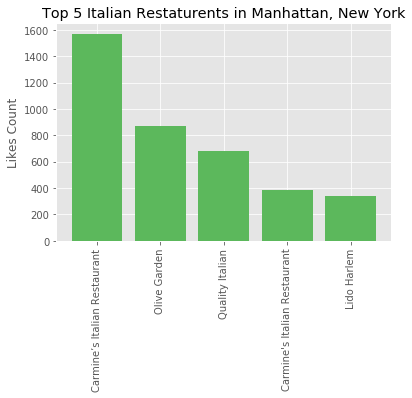

In [280]:
pos = np.arange(len(counts))
plt.figsize=(20, 8)
bar_width = 0.3
plt.bar(pos, counts, color='#5cb85c')
plt.xticks(pos, venueslist, rotation=90)
plt.ylabel("Likes Count")
plt.title("Top 5 Italian Restaturents in Manhattan, New York") 
plt.show()

Let's create Manhattan, NY map with top 5 venues superimposed on top.

In [281]:
map_venues = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(top5_venues['lat'], top5_venues['lng'], top5_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venues)  
    
map_venues

Used Foursquare API to get venue rating, though rating is not avaialble for all the venues

In [282]:
#set up to pull the likes from the API based on venue ID
venue_id_list = nearby_venues_sort_by_likes['id'].tolist()
url_list = []
likes_count_list = []
rating_list = []
json_list = []


for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    try:
       rating = result['response']['venue']['rating']
    except:
       rating = 'NA'    
    rating_list.append(rating) 

print(rating_list)

[8.8, 8.2, 8.8, 8.3, 8.6, 7.9, 9.2, 6.7, 7.3, 6.7, 6.4, 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']


Add the rating column to nearby_venues_sort_by_likes dataframe and view the resulting dataset. It is noticed that all the top 5 venues ranked by likes count got more than 8 rating and the top ranked venue got the higest rating of 8.8

In [283]:
nearby_venues_sort_by_likes['rating'] = rating_list
nearby_venues_sort_by_likes.head()

,id,name,categories,lat,lng,likes count,grade,cluster,rating
2,3fd66200f964a5209ee81ee3,Carmine’s Italian Restaurant,Italian Restaurant,40.757497,-73.986779,1570,awesome,1,8.8
7,42f15a80f964a520bb261fe3,Olive Garden,Italian Restaurant,40.759414,-73.984702,867,awesome,1,8.2
1,51e7310c498e639ed27062b1,Quality Italian,Italian Restaurant,40.764476,-73.977032,678,awesome,1,8.8
0,4a7778a1f964a5209be41fe3,Carmine's Italian Restaurant,Italian Restaurant,40.791096,-73.973991,385,great,3,8.3
13,4d573d8aa747b60cc83b332b,Lido Harlem,Italian Restaurant,40.804987,-73.954885,337,great,3,8.6
